# Solving the n-Queens Problem using Local Search

## Instructions

Total Points: Undergrads 100 / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a PDF file. 


## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum. 

## Helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""
    
    return(np.random.randint(0,n, size = n))

def comb2(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

def conflicts(board):
    """Caclulate the number of conflicts, i.e., the objective function."""

    n = len(board)
    
    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n
    
    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1
    
    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))


def show_board(board, cols = ['white', 'gray'], fontsize = 48):  
    """display the board"""
    
    n = len(board)
    
    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0): 
                display[i,j] = 1
    
    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap, 
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])
    
    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize, 
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    
    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()

In [2]:
from numba import njit

# with jit (cannot use some Python functions like sum)
@njit()
def comb2_jit(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

@njit()
def conflicts_jit(board):
    """Caclulate the number of conflicts, i.e., the objective function."""

    n = len(board)
 
    cnt = [0] * (5 * n)
 
    for i in range(n):
        cnt[board[i]] += 1
        cnt[(n) + (i + board[i])] += 1
        cnt[(3 * n) + (i - board[i] + n)] += 1
 
    conflicts = 0
    for x in cnt:
        conflicts += comb2_jit(x)
 
    return conflicts

Code received from n_queens_fast_conflict_calculation_with_numba

## Create a board

Board with 4 conflicts.


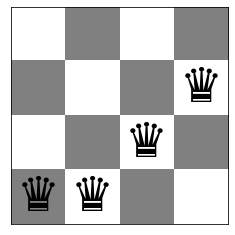

Queens (left to right) are at rows: [3 3 2 1]
Number of conflicts: 4


In [3]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


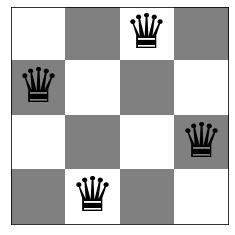

In [4]:
board = [1,3,0,2]
show_board(board)

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Steepest-ascend Hill Climbing Search [30 Points]

Calculate the objective function for all local moves (see definition of local moves above) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum. 

In [5]:
# Code and description go here
def HillClimbing(size, moveFunc):
    current = random_board(size)
    while True: 
        neighbor = moveFunc(current)
        if conflicts_jit(neighbor) >= conflicts_jit(current): return current
        current = neighbor

In [6]:
import copy
import pandas as pd

def SteepestAscendHillClimb(maze):
    size = len(maze)
    localMoves = []
    conflicts = []
    for i in range(size):
        curMaze = copy.deepcopy(maze)
        for j in range(size):
            if j != maze[i]:
                curMaze[i] = j
                localMoves.append(copy.deepcopy(curMaze))
                conflicts.append(conflicts_jit(curMaze))
    return localMoves[pd.Series(conflicts).idxmin()]
        
# m = HillClimbingRandomRestart(3, SteepestAscendHillClimb)
# show_board(m)

## Task 2: Stochastic Hill Climbing 1 [10 Points]

Chooses randomly from among all uphill moves till you have reached a local optimum.

In [7]:
import random

# Code and description go here
def StochasticHillClimb(maze):
    originalConflicts = conflicts_jit(maze)
    size = len(maze)
    localUpHillMoves = []
    for i in range(size):
        curMaze = copy.deepcopy(maze)
        for j in range(size):
            if j != maze[i]:
                curMaze[i] = j
                if(conflicts_jit(curMaze) < originalConflicts):
                    localUpHillMoves.append(copy.deepcopy(curMaze))
                    
    if len(localUpHillMoves) > 0: return random.choice(localUpHillMoves)
    return maze

# m = HillClimbing(10, StochasticHillClimb)
# show_board(m)

## Task 3: Stochastic Hill Climbing 2 [20 Points]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__ 

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

In [8]:
# Code and description go here

def createRandomLocalMove(maze):
    curMaze = copy.deepcopy(maze)
    column = random.randint(0, len(maze)-1)
    newRow = random.randint(0, len(maze)-1)
    while(newRow == maze[column]):
        newRow = random.randint(0, len(maze)-1)
    curMaze[column] = newRow
    return curMaze
    
def StochasticHillClimb2(maze):
    originalConflicts = conflicts_jit(maze)
    for i in range(len(maze)*50):
        curMaze = createRandomLocalMove(maze)  
        curConflicts = conflicts_jit(curMaze)
        if curConflicts < originalConflicts: return curMaze
    return maze

## Task 4: Hill Climbing Search with Random Restarts [10 Points]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algoithm several times starting with a new random board.

In [9]:
# Code and description go here
# Code and description go here
def HillClimbingRandomRestarts(size, moveFunc):
    current = random_board(size)
    best = current
    while conflicts_jit(best) != 0: 
        neighbor = moveFunc(current)
        if conflicts_jit(neighbor) >= conflicts_jit(current): 
            best = current
            current = random_board(size)
        else:
            current = neighbor
    return best

# show_board(HillClimbingRandomRestarts(30, SteepestAscendHillClimb))
# show_board(HillClimbingRandomRestarts(30, StochasticHillClimb))
# show_board(HillClimbingRandomRestarts(30, StochasticHillClimb2))

## Task 5: Compare Performance [20 Points]

Use runtime and objective function value to compare the algorithms. 

* Use boards of different sizes to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 10 times) with different starting boards and report averages.

* How do the algorithms scale with problem size? Use tables and charts.

* What is the largest board each algorithm can solve in a reasonable amount time?

See [Profiling Python Code](../Python_Code_Examples/profiling_code.ipynb) for help about how to measure runtime in Python.

In [25]:
# Code, results, charts and discussion go here
import time

sizes = [4,5,6,8,10,15,20,30]

steepestTime = []
stochasticTime = []
stochastic2Time = []

for i in sizes:
    curSteepestTime = []
    curStochasticTime = []
    curStochastic2Time = []
    for j in range(50):
        tic = time.perf_counter()
        HillClimbingRandomRestarts(i, SteepestAscendHillClimb)
        toc = time.perf_counter()
        curSteepestTime.append(toc-tic)
        
        tic = time.perf_counter()
        HillClimbingRandomRestarts(i, StochasticHillClimb)
        toc = time.perf_counter()
        curStochasticTime.append(toc-tic)

        tic = time.perf_counter()
        HillClimbingRandomRestarts(i, StochasticHillClimb2)
        toc = time.perf_counter()
        curStochastic2Time.append(toc-tic)
        
    
    steepestTime.append(np.average(curSteepestTime))
    stochasticTime.append(np.average(curStochasticTime))
    stochastic2Time.append(np.average(curStochastic2Time))

In [27]:
df = pd.DataFrame({
    'Size': sizes, 
    'Steepest Ascend Hill Climb': steepestTime, 
    'Stochastic Hill Climb': stochasticTime,
    'Stochastic Hill Climb 2': stochastic2Time
}, index=['4x4','5x5','6x6','8x8','10x10','15x15','20x20','30x30'])
df

,Size,Steepest Ascend Hill Climb,Stochastic Hill Climb,Stochastic Hill Climb 2
4x4,4,0.000900,0.000249,0.002278
5x5,5,0.000494,0.000198,0.001826
6x6,6,0.004196,0.002172,0.012578
8x8,8,0.006805,0.003917,0.015705
10x10,10,0.021358,0.016704,0.050896
15x15,15,0.144181,0.088033,0.146721
20x20,20,0.399910,0.370453,0.492442
30x30,30,3.304446,3.454071,2.474693


Text(0.5, 0, 'Size of board')

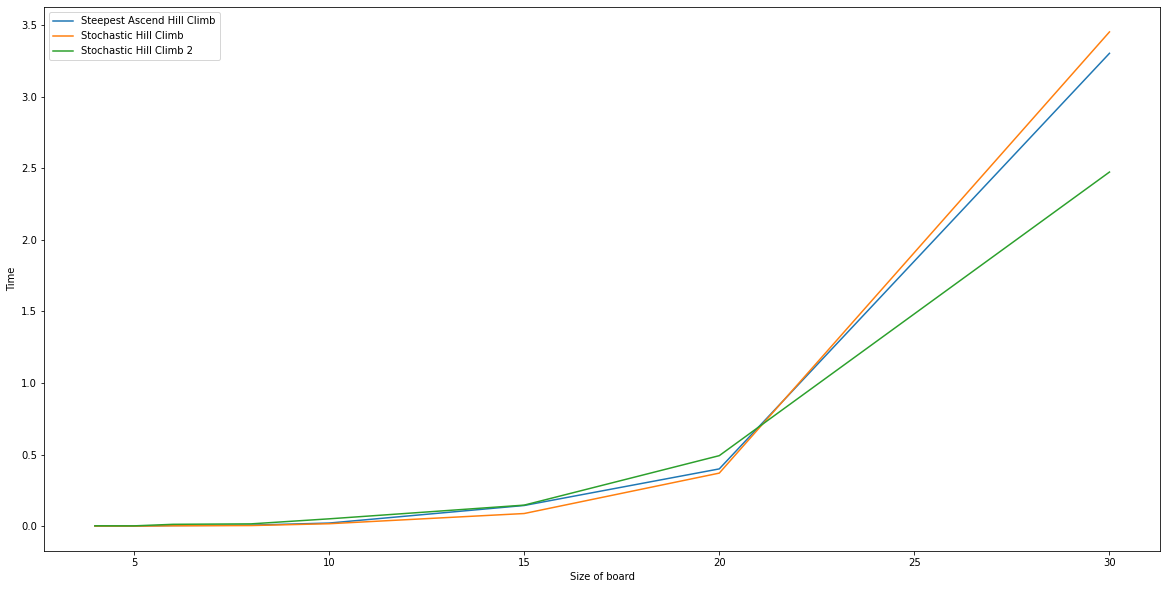

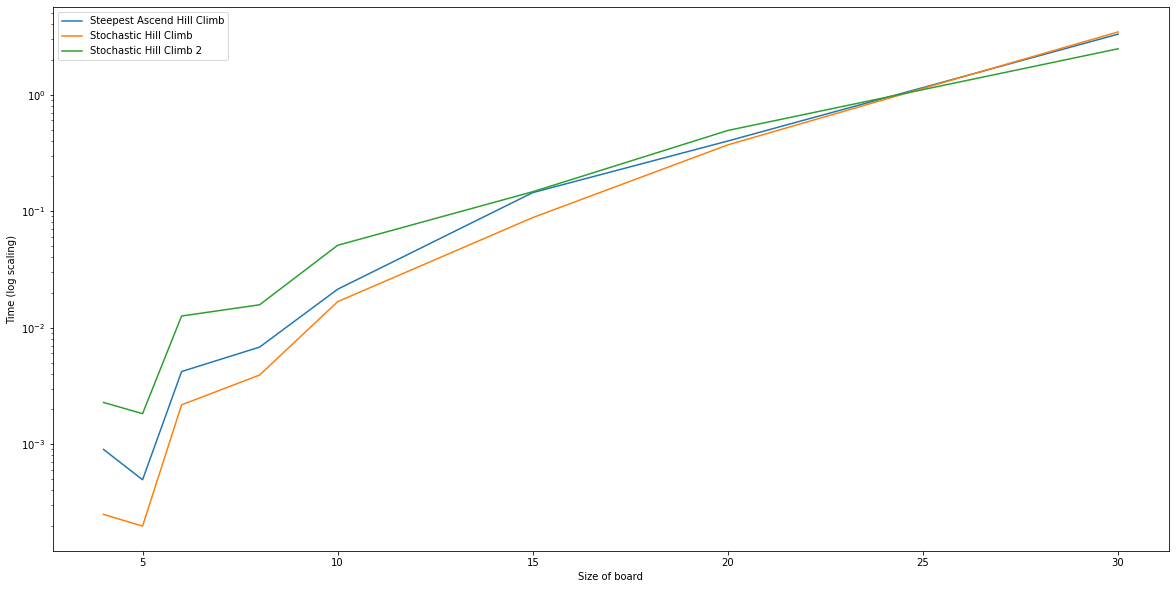

In [28]:
# Your graphs and discussion of the results goes here
ax1 = df.plot.line(
    x='Size',
    y=['Steepest Ascend Hill Climb','Stochastic Hill Climb','Stochastic Hill Climb 2'], 
    figsize=(20, 10)
)
ax1.set_ylabel("Time")
ax1.set_xlabel("Size of board")

ax2 = df.plot.line(
    x='Size',
    y=['Steepest Ascend Hill Climb','Stochastic Hill Climb','Stochastic Hill Climb 2'], 
    figsize=(20, 10),
    logy=True
)
ax2.set_ylabel("Time (log scaling)")
ax2.set_xlabel("Size of board")

 ## Discussion

Use boards of different sizes to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 10 times) with different starting boards and report averages.

How do the algorithms scale with problem size? Use tables and charts.

What is the largest board each algorithm can solve in a reasonable amount time?

Shown by the both the graphs, all three functions seem to scale exponentially. It is obvious in the second graph which is a log scale because the lines seem to be almost linear on the log scale as the problem size grows.There is not a clear definition of how much a reasonable amount of time is so decided to make it 1 minute. 

For the three algorithms, the largest board they can solve in around 1 minute is:
* Steepeset Ascent Hill Climb: n = 50-55
* Stochastic Hill Climb: n = 40-45
* Stochastic Hill Climb 2: n = 60-65

In [38]:
%%time
conflicts_jit(HillClimbingRandomRestarts(50, SteepestAscendHillClimb))

CPU times: user 49.7 s, sys: 126 ms, total: 49.8 s
Wall time: 49.8 s


0

In [47]:
%%time
conflicts_jit(HillClimbingRandomRestarts(40, StochasticHillClimb))

CPU times: user 47.6 s, sys: 93.8 ms, total: 47.7 s
Wall time: 47.7 s


0

In [40]:
%%time
conflicts_jit(HillClimbingRandomRestarts(60, StochasticHillClimb2))

CPU times: user 55.2 s, sys: 100 ms, total: 55.3 s
Wall time: 55.3 s


0